### Barebones Implementation of SIFT

In [1]:
import cv2 as cv
import numpy as np
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import utils
import math

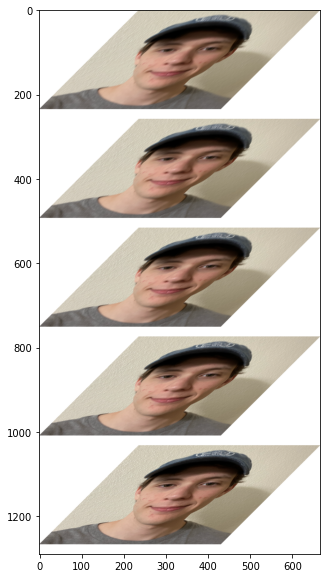

In [2]:
k = math.sqrt(2)
sigma = 1
src = cv.imread("./imgs/me.PNG", cv.IMREAD_COLOR)
src = cv.cvtColor(src, cv.COLOR_BGR2RGB)
img = src.copy()
n_octaves = 4
oct_size = 5

octaves = []
for i in range(n_octaves):
    octave = utils.gen_octave(img, oct_size)
    img = cv.resize(img, (img.shape[0] // 2, img.shape[0] // 2))
    octaves.append(octave)

sample_oct_idx = 0
plt.figure(figsize=(10,10))
plt.imshow(utils.stack_imgs(octaves[sample_oct_idx]))

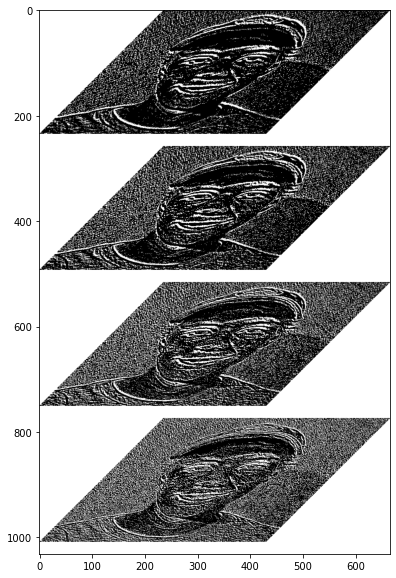

In [3]:
sample_octave = octaves[sample_oct_idx]
for i, scale in enumerate(sample_octave):
   sample_octave[i] = cv.cvtColor(scale, cv.COLOR_BGR2GRAY)

DoGs = []
for i in range(len(sample_octave ) - 1):
    sub_img = sample_octave[i + 1] - sample_octave[i]
    DoGs.append(sub_img)

plt.figure(figsize=(10,10))
stacked = utils.stack_imgs(DoGs)
plt.imshow(stacked, cmap = "gray")

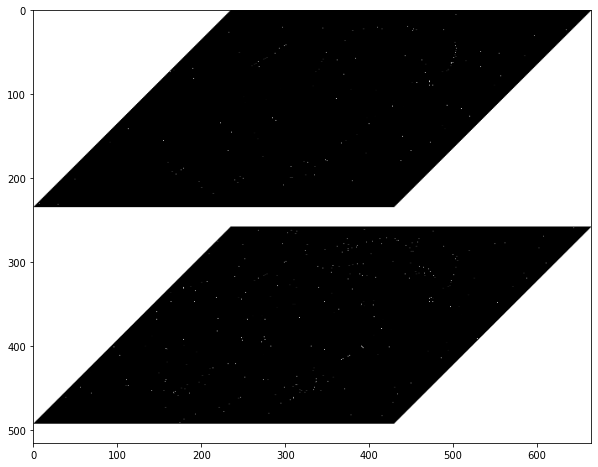

In [4]:
sample_scale_idx = 1
candidate1_map, candidates1 = utils.extrema_detection(DoGs, sample_scale_idx)
candidate2_map, candidates2 = utils.extrema_detection(DoGs, sample_scale_idx + 1)

plt.figure(figsize=(10,10))
stacked = utils.stack_imgs([candidate1_map, candidate2_map])
plt.imshow(stacked, cmap = "gray")

number of keypoints on sample before: 501


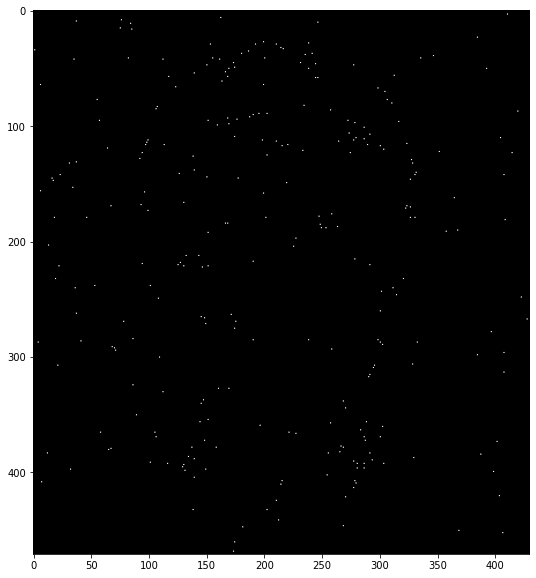

In [5]:
print(f"number of keypoints on sample before: {len(candidates1)}")

plt.figure(figsize=(10, 10))
plt.imshow(candidate1_map, cmap="gray")

number of keypoints on sample after refinement: 229


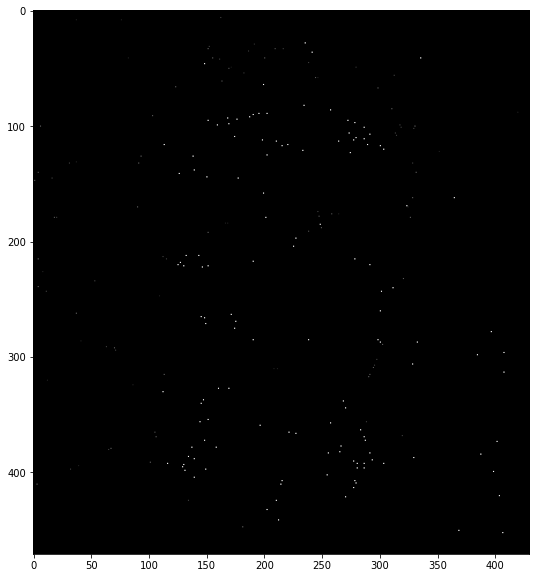

In [6]:
refined_map, refined1 = utils.keypoint_inter(DoGs, candidates1)
_, refined2 = utils.keypoint_inter(DoGs, candidates2)
print(f"number of keypoints on sample after refinement: {len(refined1)}")

plt.figure(figsize=(10, 10))
plt.imshow(refined_map, cmap="gray")

number of keypoints on sample after eliminating edge points: 90


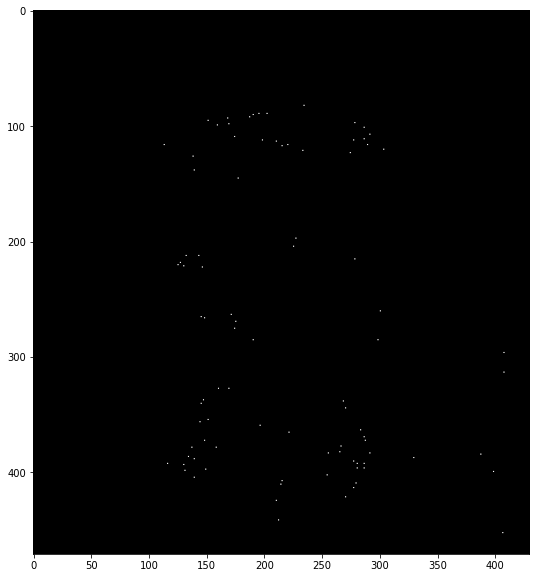

In [7]:
# They use r=10 in the original paper, 
# but for demonstration I chose a very extreme value
# you should use the default in practice

refined_map, keypoints1 = utils.elim_edge_responses(DoGs, refined1, r=1.001)
_, keypoints2 = utils.elim_edge_responses(DoGs, refined2, r=1.001)
print(f"number of keypoints on sample after eliminating edge points: {len(keypoints1)}")

plt.figure(figsize=(10, 10))
plt.imshow(refined_map, cmap="gray")

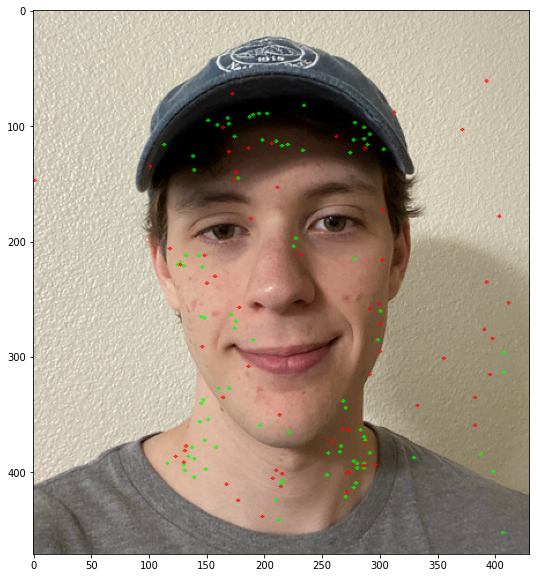

In [8]:
#  convert kps to absolute coordinates
global_kps1 = utils.convert_keypoints(keypoints1, sample_oct_idx, oct_size, sigma, k)
global_kps2 = utils.convert_keypoints(keypoints2, sample_oct_idx, oct_size, sigma, k)
img_kp = src.copy()

for kp in global_kps1:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv.circle(img_kp, pt, 1, (0, 255, 0), 1, cv.LINE_AA)
for kp in global_kps2:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv.circle(img_kp, pt, 1, (255, 0, 0), 1, cv.LINE_AA)

plt.figure(figsize=(10, 10))
plt.imshow(img_kp)

In [9]:
sample_hists, ori_kps1 = utils.compute_orientations(global_kps1, octaves, sample_oct_idx, k)
_, ori_kps2 = utils.compute_orientations(global_kps2, octaves, sample_oct_idx, k)

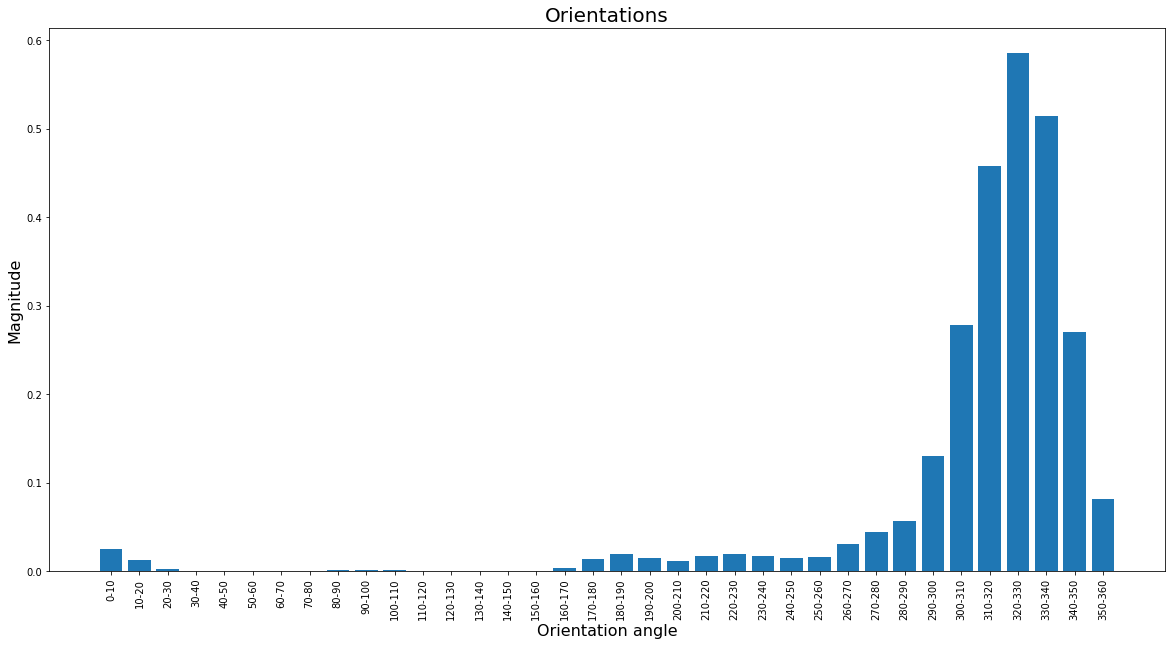

In [18]:
sample_kp = np.random.randint(0, len(global_kps1))
hist, _smooth_hist = sample_hists[sample_kp]
norm = np.linalg.norm(_smooth_hist)
_smooth_hist = np.array(_smooth_hist) / norm

# show_hist(hist, "Orientations")
utils.show_hist(_smooth_hist, "Orientations")


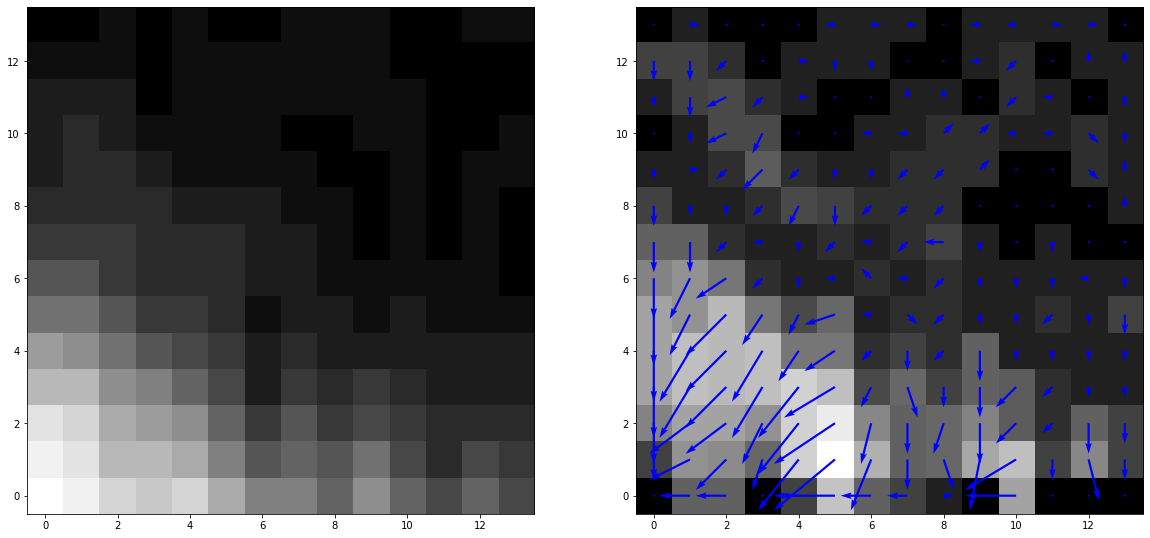

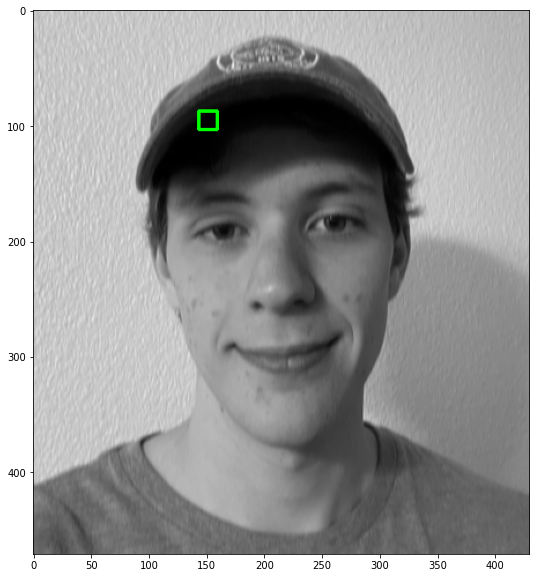

In [19]:
kp = ori_kps1[sample_kp]
utils.show_patch_structure(
    _smooth_hist, octaves, kp, sample_oct_idx, sample_scale_idx
)

In [16]:
# img_kp = src.copy()
# cv.drawKeypoints(img_kp, ori_kps1, img_kp, color=(0,255,0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
# cv.drawKeypoints(img_kp, ori_kps2, img_kp, color=(0,128,0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

# plt.figure(figsize=(10, 10))
# plt.imshow(img_kp)

### continue with descriptor generation